In [13]:
!pip install --upgrade pip
!pip install --upgrade pypdf langchain-text-splitters langchain-community langgraph faiss-cpu langchain-openai python-dotenv rapidocr-onnxruntime langsmith
!pip install -qU "langchain[openai]"

In [14]:
import os
from dotenv import load_dotenv
from pypdf import PdfReader
from langgraph.graph import StateGraph, MessagesState
from langchain_core.messages import SystemMessage
from langchain_core.tools import tool
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain.chat_models import init_chat_model
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from IPython.display import Image, display

In [15]:
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGSMITH_TRACING = os.getenv("LANGSMITH_TRACING", "false")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY", "not provided")

In [4]:
def load_pdfs_recursively(directory):
    all_pages = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(".pdf"):
                pdf_path = os.path.join(root, file)
                try:
                    with open(pdf_path, 'rb') as f:
                        PdfReader(f)  # will raise an exception if the PDF is invalid

                    loader = PyPDFLoader(pdf_path, extract_images=False)  # set to False unless you NEED images
                    pages = loader.load()
                    all_pages.extend(pages)
                except Exception as e:
                    print(f"Error processing {pdf_path}: {e}")
    return all_pages

pdf_directory = "pdfs"  # path to dir with PDFs
docs = load_pdfs_recursively(pdf_directory)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = FAISS.from_documents(all_splits, embeddings)

print("Index created!")

Index created!


In [16]:
graph_builder = StateGraph(MessagesState)

In [17]:
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [7]:
# Invoke LLM
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [8]:
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

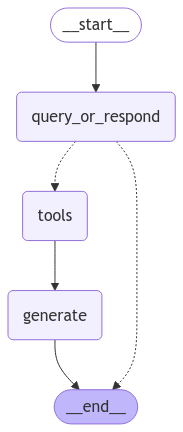

In [9]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [11]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [12]:
input_message = "What should I highlight on an Academic Resume?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What should I highlight on an Academic Resume?
================================== Ai Message ==================================

When creating an academic resume, it's important to highlight specific elements that reflect your scholarly accomplishments and qualifications. Here are some key sections to include:

1. **Contact Information**: Include your name, address, phone number, and professional email.

2. **Objective or Summary**: A brief statement outlining your academic and professional goals.

3. **Education**: List your degrees (with majors/minors), institutions, and graduation dates. Consider including relevant coursework if applicable.

4. **Research Experience**: Highlight any research projects, your role, methodologies used, and key findings or contributions.

5. **Publications and Presentations**: Include articles, papers, or posters you've authored or co-authored, along with conferences where 

In [19]:
input_message = "What was Sanjana Singh's last occupation?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What was Sanjana Singh's last occupation?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_Oc3NvUYdDgvv4YRyUHegFbxM)
 Call ID: call_Oc3NvUYdDgvv4YRyUHegFbxM
  Args:
    query: Sanjana Singh last occupation
================================= Tool Message =================================
Name: retrieve

Source: {'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign 15.0 (Macintosh)', 'creationdate': '2021-03-15T11:19:21-04:00', 'moddate': '2021-03-15T11:23:17-04:00', 'title': 'Creating Your Academic CV For Masters and PhDs', 'trapped': '/False', 'source': 'pdfs/Creating-Your-Academic-CV.pdf', 'total_pages': 20, 'page': 6, 'page_label': '7'}
Content: 7
CV sample 1
Sanjana Singh 
567 Toronto Street ·Toronto, ON M4Y 2T9 Canada · Tel: (416) 123-4567 · email: s.singh@utoronto.ca 
EDUCATION
Doctor of Pharmacy, University of Toronto 2020
Hospi